In [3]:
import tensorflow as tf
import numpy as np
import h5py
import keras
from keras.layers import Input
from keras.models import Model
from keras.optimizers import SGD
from keras.datasets import cifar10,cifar100
import keras.backend as K
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, TensorBoard
import sys
import os
import time
import argparse

if __package__ is None:
    sys.path
    sys.path.insert(0, '/Users/yizuotian/pyspace')
    __package__ = "keras-lbl-IvS"
    
from .config import Config
from .utils import random_select, get_weights, update_weights, update_queue
from .faiss_utils import get_index, update_multi

Using TensorFlow backend.


## 配置信息

In [6]:
class CifarConfig(Config):
    # 输入信息
    input_shape = (32, 32, 3)
    num_classes = 100  # cifar100

    # 训练参数
    batch_size = 30

    # 原型权重保存
    prototype_weights_hdf5 = '/tmp/cifar_prototype_weights.hdf5'
    prototype_weights_dataset = 'cifar_prototype_weights_set'
    pw_h5_file = None  # hdf5 File文件

    index = None  # 保存原型类别的faiss索引

    dominant_queue = None  # 支配队列
    candidate_queue = None  # 候选队列

    dominant_queue_num = 10  # 支配队列大小
    candidate_queue_num = 30  # 候选队列大小

config = CifarConfig()

In [7]:
def set_gpu_growth():
    os.environ["CUDA_VISIBLE_DEVICES"] = "0"
    cfg = tf.ConfigProto()
    cfg.gpu_options.allow_growth = True
    session = tf.Session(config=cfg)
    K.set_session(session)
    
set_gpu_growth()

In [8]:
import matplotlib.pyplot as plt
def img_show(X, rows, cols):
    plt.figure(figsize=(cols * 1.5, rows))
    for i, img in enumerate(X[:rows * cols]):
        plt.subplot(rows, cols, 1 + i)
        plt.imshow(img)
    plt.show()

## 源数据集训练

使用cifar10 作为源数据集

### cifar10 数据集加载、可视化

In [9]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

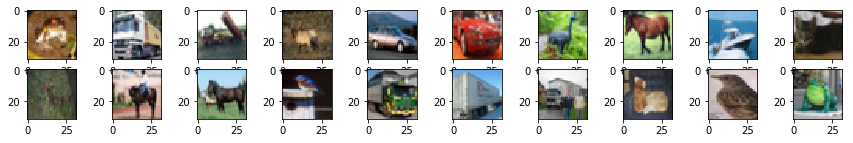

In [10]:
img_show(x_train,2,10)

### 骨干网络定义

骨干网络，提取特征

In [11]:
# 骨干网络，提取特征
import keras.layers as layers
def cifar_base_net(inputs):
    """
    骨干网络、用于提取特征
    :param inputs: keras Input对象
    :return: 
    """
    x = layers.Conv2D(32, (3, 3), padding='same', name='conv_1')(inputs)
    x = layers.BatchNormalization(axis=3, name='bn_conv1')(x)
    x = layers.Activation('relu')(x)
    x = layers.Conv2D(32, (3, 3), name='conv_2')(x)
    x = layers.Activation('relu')(x)
    x = layers.MaxPooling2D(pool_size=(2, 2))(x)
    x = layers.Dropout(0.25)(x)

    x = layers.Conv2D(64, (3, 3), padding='same', name='conv_3')(x)
    x = layers.Activation('relu')(x)
    x = layers.Conv2D(64, (3, 3), name='conv_4')(x)
    x = layers.Activation('relu')(x)
    x = layers.MaxPooling2D(pool_size=(2, 2))(x)
    x = layers.Dropout(0.25)(x)

    x = layers.Conv2D(512, (3, 3), name='conv_5')(x)
    x = layers.Activation('relu')(x)
    x = layers.GlobalAvgPool2D()(x)

    return x

### AMSoftmax分类层定义

关于AMSoftmax的详细信息见论文:[Additive Margin Softmax for Face Verification](https://arxiv.org/abs/1801.05599)

In [12]:
from keras.layers import Layer
class DenseWithAMSoftmaxLoss(Layer):

    def __init__(self, num_classes, m=0.35, scale=30, **kwargs):
        """
        根据Additive Margin Softmaxfor Face Veriﬁcation论文设置m和scale
        :param num_classes: 类别数
        :param m: margin间隔
        :param scale: 尺度
        :param kwargs:
        """
        self.output_dim = num_classes
        self.m = m
        self.scale = scale
        super(DenseWithAMSoftmaxLoss, self).__init__(**kwargs)

    def build(self, input_shape):
        # 添加可训练参数
        self.kernel = self.add_weight(name='kernel',
                                      shape=(input_shape[1], self.output_dim),
                                      initializer='glorot_normal',
                                      trainable=True)

    def call(self, inputs):
        self.inputs = inputs
        # L2归一化
        self.w_norm = K.tf.nn.l2_normalize(self.kernel, 0, 1e-10)
        self.x_norm = K.tf.nn.l2_normalize(self.inputs, 1, 1e-10)
        self.logits = K.dot(self.x_norm, self.w_norm)
        return self.logits

    def compute_output_shape(self, input_shape):
        return (input_shape[0],  # batch_size
                self.output_dim)

    def loss_dense(self, y_true, y_pred):
        """
        AmSoftmax Loss
        :param y_true: 真实类别 [N,num_classes]
        :param y_pred: 预测类别[N,num_classes]
        :return:
        """
        y_true = K.cast(y_true, 'float32')
        thelta_m = y_pred - y_true * self.m  # cosine(thelta)-m ; y_true 就相当于mask

        return K.categorical_crossentropy(y_true, self.scale * thelta_m, from_logits=True)


### 构建模型

In [12]:
from keras.models import Model
from keras.layers import Dense
from keras import Input

def source_model(img_inputs,num_class):
    features=cifar_base_net(img_inputs)
    dense=DenseWithAMSoftmaxLoss(num_class)   # 使用自定义的AMSoftMax分类层 
    output=dense(features)
    m = Model(img_inputs,output)
    m.compile(optimizer=keras.optimizers.Adam(lr=0.1,decay=1e-6),
          loss=dense.loss_dense,
          metrics=['accuracy'])
    return m

img_input=Input(shape=(32,32,3))
m = source_model(img_input,10)  # cifar10 一共10类
m.summary()

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See @{tf.nn.softmax_cross_entropy_with_logits_v2}.

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 32, 32, 3)         0         
_________________________________________________________________
conv_1 (Conv2D)              (None, 32, 32, 32)        896       
_________________________________________________________________
bn_conv1 (BatchNormalization (None, 32, 32, 32)        128       
_________________________________________________________________
activation_1 (Activation)    (None, 32, 32, 32)        0         
_________________________________________________________________
conv_2 (Conv2D)              (None, 30, 30, 32)        9248      
_________________________________________________________________
activation_2 (Ac

### 训练模型

In [15]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
m.fit(x_train, keras.utils.to_categorical(y_train,10),
              batch_size=64,
              epochs=10,
              validation_data=(x_test, keras.utils.to_categorical(y_test,10)),
              shuffle=True)

Train on 50000 samples, validate on 10000 samples
Epoch 1/10
10240/50000 [=====>........................] - ETA: 5:31 - loss: 12.7981 - acc: 0.1083

KeyboardInterrupt: 

In [17]:
m.save('/tmp/source.weights.h5')

## 初始评估

使用在源数据集cifar10上训练的模型，来评估在cifar100上的精度;评估方式是通过imprint构建初始的分类权重;
imprint详见[Low-Shot Learning with Imprinted Weights](https://arxiv.org/abs/1712.07136)论文，相关代码见[keras-imprinting](https://github.com/yizt/keras-imprinting).


### cifar100 数据加载、可视化

In [13]:
(x_train, y_train), (x_test, y_test) = cifar100.load_data()

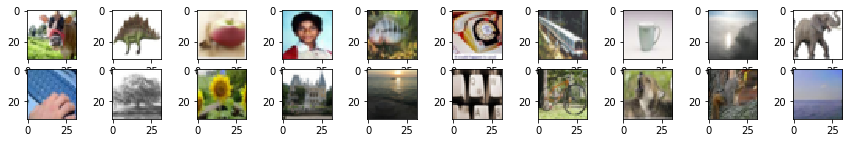

In [14]:
img_show(x_train,2,10)

### 初始原型权重

使用imprint方式将cifar100的类别原型权重保持到hdf5中(虽然这里只有100类，但是也按照类别上百万的方式来实现)

In [17]:
# 类别分组
def label_id_map(labels, num_class):
    """
    将图像按照类别分组
    """
    # 初始化
    label_id_dict = dict()
    for i in range(num_class):
        label_id_dict[i] = []

    # 逐个图像归类
    for img_id in range(len(labels)):
        label_id_dict[labels[img_id]].append(img_id)
    return label_id_dict
label_id_dict = label_id_map(y_train[:,0], config.num_classes)  # y_train (5000,1)

In [18]:
# 初始化原型权重
def init_prototype(pretrained_weights, X, label_id_dict, num_class):
    inputs = Input(batch_shape=(config.batch_size,) + config.input_shape)
    features = cifar_base_net(inputs)
    model = Model(inputs, features)
    model.load_weights(pretrained_weights, by_name=True)
    # 原型权重一份放到hdf5，一份存放到faiss中(faiss中保留的不是精准的)
    f_label = h5py.File(config.prototype_weights_hdf5, 'w')
    label_feature = f_label.create_dataset(config.prototype_weights_dataset,
                                           shape=(num_class, 512), dtype='f')

    # 逐个类别处理
    for label in range(num_class):
        # 获取某个label的所有图像，并使用模型预测图像的特征，最后求均值作为label的原型权重
        image_ids = label_id_dict[label]  # 图像id
        images = X[image_ids]  # 图像数据
        features = model.predict(np.asarray(images))  # 输出特征
        features = keras.utils.np_utils.normalize(features)  # 归一化
        features = np.mean(features, axis=0)  # 求均值
        features = keras.utils.np_utils.normalize(features)  # 再次归一化; 是二维的

        # 赋值给hdf5
        label_feature[label] = features[0]  # (1,d) 转为 (d,)
        # 每1w次，刷写到磁盘
        if label % 1000 == 0:
            f_label.flush()
            print("{} init_prototype 完成：{}".format(time.strftime("%Y-%m-%d %H:%M:%S", time.localtime()),
                                                   label))
    f_label.flush()
    # 最后关闭文件
    f_label.close()

In [45]:
init_prototype('/tmp/source.weights.h5',x_train,
               label_id_dict,
               config.num_classes)

2019-01-11 19:03:03 init_prototype 完成：0


### 开始评估

In [19]:
# 定义评估函数
from keras.layers import Dense
def evaluate(pretrained_weights, X, y, num_class, use_amsoftmax=False):
    if use_amsoftmax:
        dense = DenseWithAMSoftmaxLoss(num_class, m=0.2, scale=24.,name='other')  # name='other'
    else:
        dense = layers.Dense(num_class, use_bias=False, activation='softmax')
    # 构建模型
    inputs = Input(shape=config.input_shape)
    features = cifar_base_net(inputs)
    outputs = dense(features)
    m = Model(inputs, outputs)

    m.load_weights(pretrained_weights, by_name=True)

    # 设置分类层的权重
    f_label = h5py.File(config.prototype_weights_hdf5, 'r')
    weights = f_label[config.prototype_weights_dataset]  # HDF5 dataset object
    m.layers[-1].set_weights([np.transpose(weights[:])])  # 使用weights[:]转为numpy
    # 最后关闭文件
    f_label.close()
    #m.summary()

    # 评估预测
    y_pred = m.predict(X)
    y_pred = np.argmax(y_pred, axis=-1)

    print("sum:{},acc:{}".format(np.sum(np.equal(y,y_pred)),np.mean(np.equal(y,y_pred))))

In [21]:
#y_train = keras.utils.to_categorical(y_train, 100)
#y_test = keras.utils.to_categorical(y_test, 100)
w='/tmp/source.weights.h5'
init_prototype(w,x_train,
               label_id_dict,
               config.num_classes)
evaluate(w, x_test,keras.utils.to_categorical(y_test, 100),config.num_classes,True)

2019-01-13 15:53:59 init_prototype 完成：0
sum:2085,acc:0.2085


In [162]:
f_label = h5py.File(config.prototype_weights_hdf5, 'r')
weights = f_label[config.prototype_weights_dataset]  # HDF5 dataset object
np.mean(weights[:]),np.mean(np.max(weights[:]))

(0.025562823, 0.21479483)

## 支配原型训练cifar100

### 获取原型

获取保持在hdf5中的初始原型权重;并将所有的权重加载到faiss的索引中，用于候选构造支配队列和候选队列

In [22]:
def get_prototype(deal_batch=1000):
    f_label = h5py.File(config.prototype_weights_hdf5, 'r+')
    dset = f_label[config.prototype_weights_dataset]
    length = len(dset)
    index = get_index(512)
    # 逐个类别处理,更新faiss index
    for batch_no in range(length // deal_batch):
        start = batch_no * deal_batch
        end = (batch_no + 1) * deal_batch
        features = dset[start:end]
        update_multi(index, features, np.arange(start, end))
    # 处理不能整除的情况
    if not length % deal_batch == 0:
        start = length - length % deal_batch
        end = length
        features = dset[start:end]
        update_multi(index, features, np.arange(start, end))
    return f_label, index

In [23]:
config.pw_h5_file, config.index = get_prototype(1000)

### 初始化队列

根据原型权重构造支配队列和候选队列;

In [24]:
def init_queue(index, weights_set, num_class, dq_num, cq_num):
    """
    初始化候选队列和支配队列
    :param index:
    :param weights_set: h5py dataset对象
    :param num_class:
    :param dq_num:
    :param cq_num:
    :return:
    """
    data, candidate_label_idx = index.search(weights_set[:num_class], cq_num)
    dominant_label_idx = candidate_label_idx[:, :dq_num]  # 候选队列包含支配队列

    # 转为字典类型
    dominant_queue = dict(enumerate(dominant_label_idx))
    candidate_queue = dict(enumerate(candidate_label_idx))

    return dominant_queue, candidate_queue

In [25]:
config.dominant_queue, config.candidate_queue = init_queue(config.index,
                                                           config.pw_h5_file[config.prototype_weights_dataset],
                                                           config.num_classes,
                                                           config.dominant_queue_num,
                                                           config.candidate_queue_num)

### 支配原型分类层定义

关键点：
a) 将需要输出的tensor保存在权重参数中
b) 使用K.tf.control_dependencies保证修动态加载原型权重参数和输出预测结果到不训练的权重中会加入到计算图中

In [19]:
class DenseWithDPSoftmaxLoss(Layer):
    def __init__(self, num_class, m=0.35, scale=30, **kwargs):
        self.output_dim = num_class
        self.margin = m
        self.scale = scale
        super(DenseWithDPSoftmaxLoss, self).__init__(**kwargs)

    def build(self, input_shape):
        self.kernel = self.add_weight(name='kernel',
                                      shape=(input_shape[0][1], self.output_dim),  # (嵌入维度,num_class)
                                      dtype=K.floatx(),
                                      initializer='glorot_normal',
                                      trainable=True)
        self.current_selected_labels = self.add_weight(name='labels',
                                                       shape=(self.output_dim, 1),
                                                       initializer='glorot_normal',
                                                       trainable=False)
        self.y_pred = self.add_weight(name='pred',
                                      shape=(self.output_dim, self.output_dim),
                                      initializer='glorot_normal',
                                      trainable=False)

    def call(self, inputs, **kwargs):
        # 将当前step类别的权重，赋值给tensor
        weights_assign_op = K.tf.assign(self.kernel,
                                        K.transpose(inputs[1]),
                                        name='assign_weights')
        label_assign_op = K.tf.assign(self.current_selected_labels, inputs[2], name='assign_labels')
        with K.tf.control_dependencies([weights_assign_op, label_assign_op]):
            self.x_norm = K.l2_normalize(inputs[0], axis=1)
            self.kernel_norm = K.l2_normalize(self.kernel, axis=0)
            self.logit = K.dot(self.x_norm, self.kernel_norm)
        return self.logit

    def compute_output_shape(self, input_shape):
        return (input_shape[0][0],
                self.output_dim)

    def loss(self, y_true, y_pred):
        """
        DPAmSoftmax Loss
        :param y_true: 真实类别 [N,num_classes]
        :param y_pred: 预测类别[N,num_classes]
        :return:
        """
        # 首先将预测值保持到权重中
        pred_assign_op = K.tf.assign(self.y_pred,
                                     y_pred,
                                     name='assign_pred')
        with K.tf.control_dependencies([pred_assign_op]):
            y_true = K.cast(y_true, 'float32')
            thelta_m = y_pred - y_true * self.m  # cosine(thelta)-m ; y_true 就相当于mask
            losses = K.categorical_crossentropy(y_true, self.scale * thelta_m, from_logits=True)

        return losses

### 构建模型

In [21]:
def target_model(pretrained_weights, batch_size, input_shape):
    """
    目标数据集训练模型
    :param pretrained_weights: 源数据集上训练的特征提取层的权重
    :param batch_size: 
    :param input_shape: 
    :return: 
    """
    # 构建模型
    inputs = Input(batch_shape=(config.batch_size,) + config.input_shape)
    weights_inputs = Input(batch_shape=(config.batch_size, 512))
    label_inputs = Input(batch_shape=(config.batch_size, 1))  # 至少是二维的,
    features = cifar_base_net(inputs)
    dense = DenseWithDPSoftmaxLoss(config.batch_size)  # batch-size当做类别数
    outputs = dense([features, weights_inputs, label_inputs])
    m = Model([inputs, weights_inputs, label_inputs], outputs)
    m.summary()
    m.load_weights(pretrained_weights, by_name=True)
    m.compile(loss=dense.loss,
              optimizer=SGD(lr=0.01, momentum=0.9, decay=0.0005),
              metrics=['accuracy'])
    return m

In [ ]:
m=target_model('/tmp/source.weights.h5',config.batch_size,config.input_shape)

### 构建生成器

In [22]:
def generator(X, y, label_id_dict, dominant_queue, num_class, batch_size):
    """
    训练样本生成器
    :param X: 图像
    :param y: 标签
    :param label_id_dict: 类别和对应的图像id字典
    :param dominant_queue: 支配队列; 类别和对应的支配类别
    :param num_class: 类别数, 这里是100
    :param batch_size: batch_size
    :return:
    """
    while True:
        # 两级采样，首先采样batch_size/3个正类别;然后随机采样支配类别
        sample_labels = np.random.choice(num_class, batch_size // 3, replace=False)  # 无放回抽样

        selected_labels = set(sample_labels)  # 保存当前选中类别set
        selected_image_labels = []  # 保存当前step选中的图像和对应的类别标签
        # 首先选择正原型
        for label in sample_labels:
            selected_image_id = random_select(label_id_dict[label])
            selected_image_labels.append([selected_image_id, label])

        # 再选择相关的支配原型，直到mini-batch大小
        while len(selected_image_labels) < batch_size:
            # 随机采样当前正原型
            label = random_select(sample_labels)
            # 随机选择支配类别,不能是之前已经选择过的
            dq_label = random_select(dominant_queue[label])
            while dq_label in selected_labels:
                dq_label = random_select(dominant_queue[label])
            selected_labels.add(dq_label)
            # 选择支配类别的图像
            selected_image_id = random_select(label_id_dict[dq_label])
            selected_image_labels.append([selected_image_id, dq_label])
        # 当前选中标签
        selected_image_labels = np.asarray(selected_image_labels)  # 转为numpy数组
        current_selected_labels = selected_image_labels[:, 1]
        current_weights = get_weights(config.pw_h5_file[config.prototype_weights_dataset],
                                      current_selected_labels)

        # 加载图像
        images = X[current_selected_labels]
        # 返回当前mini-batch
        current_selected_labels = np.expand_dims(current_selected_labels, axis=1)

        yield [images,
               current_weights,
               current_selected_labels], np.arange(batch_size)  # 标签类别永远是0~batch_size-1

### 定义保存权重的CallBack

在训练的每个step后，将此次训练的类别原型权重导出保存到hdf5中，同时更新根据预测结果更新支配队列

In [24]:
class ExportWeights(keras.callbacks.Callback):
    def on_batch_end(self, batch, logs=None):
        layer = self.model.layers[-1]
        # 获取当前step训练后的权重、当前训练实际的标签类别，预测结果
        trained_weights, current_trained_labels, y_pred = layer.get_weights()[:3]
        trained_weights = np.transpose(trained_weights)
        current_trained_labels = np.asarray(current_trained_labels[:, 0], dtype=np.int)  # 二维转一维

        # 以下更新支配队列,根据预测结果更新支配队列;
        update_queue(config.dominant_queue,
                     config.candidate_queue,
                     y_pred,
                     current_trained_labels)

### 训练支配原型模型

In [ ]:
print("开始训练模型... ...")
gen = generator(x_train,
                label_id_dict,
                config.dominant_queue,
                config.num_classes,
                config.batch_size)

m.fit_generator(gen,
                callbacks=get_call_back(),
                steps_per_epoch=len(x_train) / 4 // config.batch_size,
                epochs=10,
                use_multiprocessing=False,
                verbose=1,
                validation_data=next(gen)
                )

## 再次评估


In [ ]:
evaluate(w, x_test,keras.utils.to_categorical(y_test, 100),config.num_classes,True)